In [2]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points,transform
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [5]:
fun = Branin(negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 10*dim
N = 10

fstar = 0.
fun = Trans_function(fun,fstar,min=True)

# GP+EI

In [6]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9


# GP+LCB

In [7]:
BO_LCB = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            beta = np.sqrt(np.log(train_Y.shape[0]))
            standard_next_X,_ = LCB_acquisition_opt(m,bounds=standard_bounds,beta=beta)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_LCB.append(best_record)

0
1
2
3
4
5
6
7
8
9


# GP+MES

In [8]:
BO_MES = []

for exp in range(N):
    
    print(exp)

    seed = exp
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0.
    

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):

            #print(i)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = np.array(best_record)+fstar 
    BO_MES.append(best_record)

0
1
2
3
4
5
6
7
8
9


# ERM

In [11]:
BO_ERM = []

for exp in range(N):

  print(exp)  
  seed = exp
  
  fstar0 = 0.
  Trans = False

  X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
  Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

  best_record = [Y_BO.min().item()]

  for iter in range(iter_num):

    #print(iter)
    train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
    train_X = normalize(X_BO, bounds)
    
    train_Y = train_Y.numpy()
    train_X = train_X.numpy()
    

    fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
    fstar_standard = fstar_standard.item()
    
    if not Trans:
      minimal = np.min(train_X)
      res = optimise(train_X,train_Y)
      kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
      m = GPy.models.GPRegression(train_X, train_Y,kernel)
      m.Gaussian_noise.variance.fix(10**(-5))

      standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
      
      beta = np.sqrt(np.log(train_X.shape[0]))
      _,lcb = LCB_acquisition_opt(m,standard_bounds,beta)
      if lcb < fstar_standard:
        Trans = True
      
    else:
      
      #print('transfromed GP')
              
      train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
      mean_temp = np.mean(train_Y_transform)
      
      res = optimise(train_X,(train_Y_transform-mean_temp))
      kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
      m = GPy.models.GPRegression(train_X, train_Y_transform-mean_temp,kernel)
      m.Gaussian_noise.variance.fix(10**(-5))
      standard_next_X,erm_value = ERM_acquisition_opt(m,bounds=standard_bounds,fstar=fstar_standard,mean_temp=mean_temp)
    
    
    X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)     
    Y_next = fun(X_next).reshape(-1,1)

    # Append data
    X_BO = torch.cat((X_BO, X_next), dim=0)
    Y_BO = torch.cat((Y_BO, Y_next), dim=0)

    best_value = float(Y_BO.min())
    best_record.append(best_value)


  best_record = np.array(best_record)+fstar
  BO_ERM.append(best_record)

0
1
2
3
4
5
6
7
8
9


# log GP+TEI

In [12]:
Warped_BO_TEI2 = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI2.append(best_record)

0
1
2
3
4
5
6
7
8
9


# plot

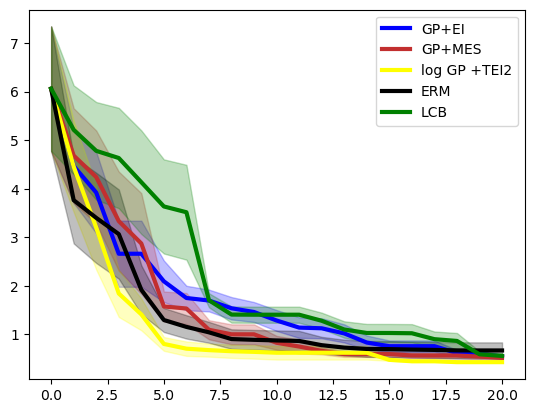

In [13]:
N = 10

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = np.array(BO_ERM)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='ERM',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

total_record = np.array(BO_LCB)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='LCB',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

plt.legend()